In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

<hr>

In [3]:
def load_and_prepare_image(image_path): 

    """ 

    Load color image and convert to grayscale. 

    Many feature detectors work on grayscale images. 

    """ 

    img_color = cv2.imread(image_path)                      # Read image in BGR format 

    if img_color is None: 

        raise FileNotFoundError(f"Cannot load image: {image_path}") 

     

    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)  # Convert BGR → Grayscale 

    return img_color, img_gray                                  # Return both versions 

In [4]:
def detect_and_compute_sift(gray_img): 

    """ 

    Detect keypoints and compute SIFT descriptors. 

    SIFT is scale & rotation invariant, 128-float descriptor. 

    """ 

    sift = cv2.SIFT_create()                            # Create SIFT detector object (OpenCV ≥4.4) 

    # You can tune parameters: nfeatures, nOctaveLayers, contrastThreshold, etc. 

    # sift = cv2.SIFT_create(nfeatures=500, contrastThreshold=0.04) 

     

    keypoints, descriptors = sift.detectAndCompute(gray_img, None) 

    # detectAndCompute() does both detection + description in one call 

    # None = no mask (use whole image) 

     

    return keypoints, descriptors 

In [5]:
def detect_and_compute_orb(gray_img, nfeatures=1500): 

    """ 

    Detect keypoints and compute ORB (binary) descriptors. 

    ORB is very fast, rotation-aware, binary (Hamming distance matching). 

    """ 

    orb = cv2.ORB_create(nfeatures=nfeatures)           # Limit max number of features 

    # Other useful params: scaleFactor=1.2, nlevels=8, edgeThreshold=31, scoreType=cv2.ORB_HARRIS_SCORE 

     

    keypoints, descriptors = orb.detectAndCompute(gray_img, None) 

    # Returns: list of KeyPoint objects + binary descriptor array (uint8) 

     

    return keypoints, descriptors

In [6]:
def detect_and_compute_surf(gray_img): 

    """ 

    Attempt to use SURF (Speeded-Up Robust Features). 

    WARNING: Often raises exception in standard pip installs because patented. 

    Only works if OpenCV was built with OPENCV_ENABLE_NONFREE=ON + contrib modules. 

    """ 

    try: 

        surf = cv2.xfeatures2d.SURF_create()            # SURF is in xfeatures2d module 

        # surf.setExtended(1)                           # Optional: 128-dim instead of 64 

        # surf.setHessianThreshold(400) 

         

        keypoints, descriptors = surf.detectAndCompute(gray_img, None) 

        return keypoints, descriptors 

    except AttributeError: 

        print("SURF is not available in this OpenCV build (patented / non-free).") 

        print("Use SIFT or ORB instead for this demonstration.") 

        return [], None 

    except cv2.error as e: 

        print("SURF error:", e) 

        print("Likely need to compile OpenCV with non-free flag.") 

        return [], None 

In [7]:
def draw_keypoints(img_color, keypoints, title="Keypoints"): 

    """ 

    Draw detected keypoints on the color image for visualization. 

    """ 

    img_with_kp = cv2.drawKeypoints( 

        img_color,  

        keypoints,  

        None,                                   # output image (None = create new) 

        color=(0, 255, 0),                      # green circles 

        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS 

        # shows orientation & scale 

    ) 

     

    # Show using matplotlib (handles RGB conversion) 

    plt.figure(figsize=(5, 4)) 

    plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB)) 

    plt.title(title) 

    plt.axis('off') 

    plt.show()

In [8]:
image_path_2 = "s.jpg" # Define the path for the second image using an available file
color_img2, gray_img2 = load_and_prepare_image(image_path_2)
print(f"Second image loaded: {gray_img2.shape}")

Second image loaded: (275, 183)


In [10]:
print("\nComputing SIFT for first image...")
kp_sift1, des_sift1 = detect_and_compute_sift(gray_img2)
print(f"SIFT (Image 1) → {len(kp_sift1)} keypoints found")

print("\nComputing SIFT for second image...")
kp_sift2, des_sift2 = detect_and_compute_sift(gray_img2)
print(f"SIFT (Image 2) → {len(kp_sift2)} keypoints found")


Computing SIFT for first image...
SIFT (Image 1) → 218 keypoints found

Computing SIFT for second image...
SIFT (Image 2) → 218 keypoints found


In [12]:
def bf_matcher_ratio_test(des1, des2):
    """
    Performs Brute-Force (BF) matching with Lowe's ratio test.
    """
    # 1. Instantiate a cv2.BFMatcher object.
    # SIFT uses floating-point descriptors, so NORM_L2 is appropriate.
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    # 2. Use knnMatch() to find the 2 best matches for each descriptor.
    # It returns k=2 nearest neighbors.
    matches = matcher.knnMatch(des1, des2, k=2)

    # 3. Apply Lowe's ratio test.
    good_matches = []
    # Ensure there are at least two matches for ratio test
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # 4. Return the list of good matches.
    return good_matches


# Perform matching for SIFT descriptors
good_matches_sift = bf_matcher_ratio_test(des_sift1, des_sift2)
print(f"Found {len(good_matches_sift)} good matches using SIFT and Ratio Test.")

Found 218 good matches using SIFT and Ratio Test.


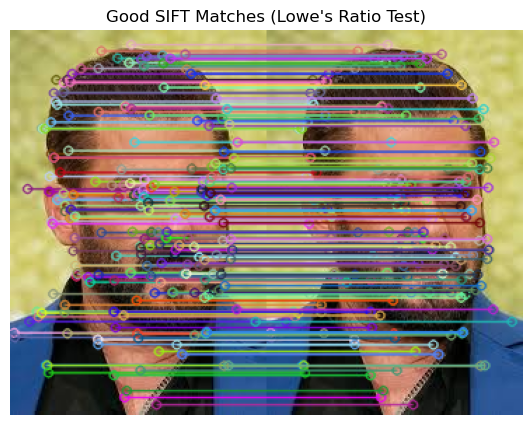

In [13]:
matched_img = cv2.drawMatches(
    color_img2,
    kp_sift1,
    color_img2,
    kp_sift2,
    good_matches_sift,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(8, 5))
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.title("Good SIFT Matches (Lowe's Ratio Test)")
plt.axis('off')
plt.show()

# ChessBoard

Image loaded: (225, 225)

Computing SIFT...
SIFT → 455 keypoints found


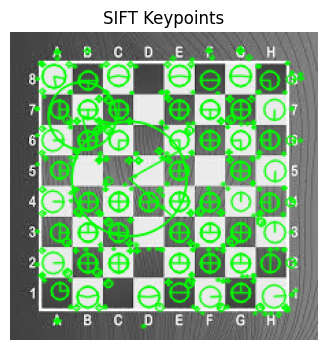


Computing ORB...
ORB  → 930 keypoints found


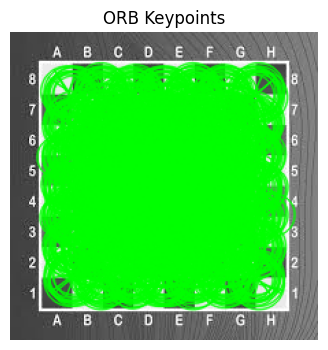


Trying SURF (may not be available)...
SURF is not available in this OpenCV build (patented / non-free).
Use SIFT or ORB instead for this demonstration.
Skipping SURF visualization.


In [25]:
def main(): 

    # ──────────────────────────────────────────────── 

    # Change this path to your test image 

    # Good choices: chessboard, building with corners/windows, textured object 

    image_path = "chess.jpg"               # ← Replace with real path 

    # image_path = "chessboard.jpg" 

    # image_path = "building facade.jpg" 

     

    try: 

        color_img, gray_img = load_and_prepare_image(image_path) 

    except FileNotFoundError as e: 

        print(e) 

        print("Please update 'image_path' variable with a valid image file.") 

        return 

     

    print(f"Image loaded: {gray_img.shape}") 

     

    # ────────────── SIFT ───────────────────────────── 

    print("\nComputing SIFT...") 

    kp_sift, des_sift = detect_and_compute_sift(gray_img) 

    print(f"SIFT → {len(kp_sift)} keypoints found") 

     

    if kp_sift: 

        draw_keypoints(color_img, kp_sift, "SIFT Keypoints") 

     

    # ────────────── ORB ────────────────────────────── 

    print("\nComputing ORB...") 

    kp_orb, des_orb = detect_and_compute_orb(gray_img, nfeatures=2000) 

    print(f"ORB  → {len(kp_orb)} keypoints found") 

     

    if kp_orb: 

        draw_keypoints(color_img, kp_orb, "ORB Keypoints") 

     

    # ────────────── SURF (may fail) ────────────────── 

    print("\nTrying SURF (may not be available)...") 

    kp_surf, des_surf = detect_and_compute_surf(gray_img) 

    if kp_surf: 

        print(f"SURF → {len(kp_surf)} keypoints found") 

        draw_keypoints(color_img, kp_surf, "SURF Keypoints") 

    else: 

        print("Skipping SURF visualization.") 

 

 

if __name__ == "__main__":

    main()

# ChessBoard 2

Image loaded: (225, 225)

Computing SIFT...
SIFT → 139 keypoints found


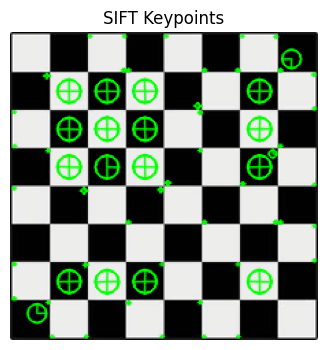


Computing ORB...
ORB  → 459 keypoints found


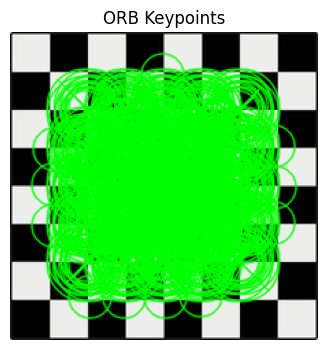


Trying SURF (may not be available)...
SURF is not available in this OpenCV build (patented / non-free).
Use SIFT or ORB instead for this demonstration.
Skipping SURF visualization.


In [26]:
def main(): 

    # ──────────────────────────────────────────────── 

    # Change this path to your test image 

    # Good choices: chessboard, building with corners/windows, textured object 

    image_path = "chess2.png"               # ← Replace with real path 

    # image_path = "chessboard.jpg" 

    # image_path = "building facade.jpg" 

     

    try: 

        color_img, gray_img = load_and_prepare_image(image_path) 

    except FileNotFoundError as e: 

        print(e) 

        print("Please update 'image_path' variable with a valid image file.") 

        return 

     

    print(f"Image loaded: {gray_img.shape}") 

     

    # ────────────── SIFT ───────────────────────────── 

    print("\nComputing SIFT...") 

    kp_sift, des_sift = detect_and_compute_sift(gray_img) 

    print(f"SIFT → {len(kp_sift)} keypoints found") 

     

    if kp_sift: 

        draw_keypoints(color_img, kp_sift, "SIFT Keypoints") 

     

    # ────────────── ORB ────────────────────────────── 

    print("\nComputing ORB...") 

    kp_orb, des_orb = detect_and_compute_orb(gray_img, nfeatures=2000) 

    print(f"ORB  → {len(kp_orb)} keypoints found") 

     

    if kp_orb: 

        draw_keypoints(color_img, kp_orb, "ORB Keypoints") 

     

    # ────────────── SURF (may fail) ────────────────── 

    print("\nTrying SURF (may not be available)...") 

    kp_surf, des_surf = detect_and_compute_surf(gray_img) 

    if kp_surf: 

        print(f"SURF → {len(kp_surf)} keypoints found") 

        draw_keypoints(color_img, kp_surf, "SURF Keypoints") 

    else: 

        print("Skipping SURF visualization.") 

 

 

if __name__ == "__main__":

    main()

<hr>

# building facade

Image loaded: (225, 225)

Computing SIFT...
SIFT → 422 keypoints found


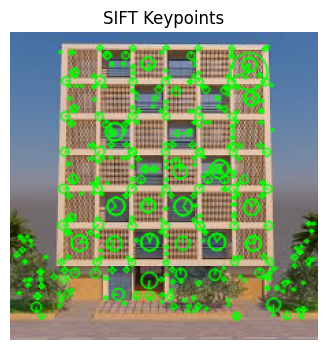


Computing ORB...
ORB  → 1160 keypoints found


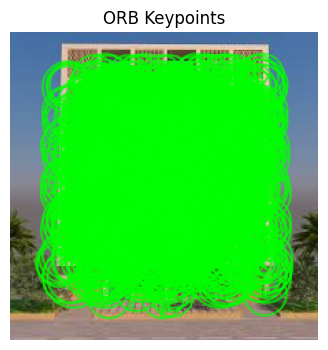


Trying SURF (may not be available)...
SURF is not available in this OpenCV build (patented / non-free).
Use SIFT or ORB instead for this demonstration.
Skipping SURF visualization.


In [27]:
def main(): 

    # ──────────────────────────────────────────────── 

    # Change this path to your test image 

    # Good choices: chessboard, building with corners/windows, textured object 

    image_path = "building facade.jpg"               # ← Replace with real path 

    # image_path = "chessboard.jpg" 

    # image_path = "building facade.jpg" 

     

    try: 

        color_img, gray_img = load_and_prepare_image(image_path) 

    except FileNotFoundError as e: 

        print(e) 

        print("Please update 'image_path' variable with a valid image file.") 

        return 

     

    print(f"Image loaded: {gray_img.shape}") 

     

    # ────────────── SIFT ───────────────────────────── 

    print("\nComputing SIFT...") 

    kp_sift, des_sift = detect_and_compute_sift(gray_img) 

    print(f"SIFT → {len(kp_sift)} keypoints found") 

     

    if kp_sift: 

        draw_keypoints(color_img, kp_sift, "SIFT Keypoints") 

     

    # ────────────── ORB ────────────────────────────── 

    print("\nComputing ORB...") 

    kp_orb, des_orb = detect_and_compute_orb(gray_img, nfeatures=2000) 

    print(f"ORB  → {len(kp_orb)} keypoints found") 

     

    if kp_orb: 

        draw_keypoints(color_img, kp_orb, "ORB Keypoints") 

     

    # ────────────── SURF (may fail) ────────────────── 

    print("\nTrying SURF (may not be available)...") 

    kp_surf, des_surf = detect_and_compute_surf(gray_img) 

    if kp_surf: 

        print(f"SURF → {len(kp_surf)} keypoints found") 

        draw_keypoints(color_img, kp_surf, "SURF Keypoints") 

    else: 

        print("Skipping SURF visualization.") 

 

 

if __name__ == "__main__":

    main()

# building facade 2

Image loaded: (183, 275)

Computing SIFT...
SIFT → 671 keypoints found


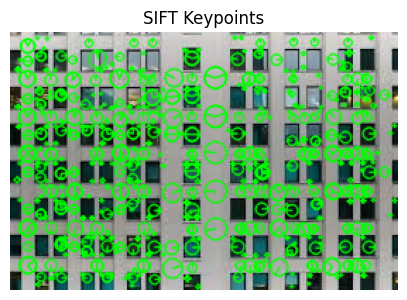


Computing ORB...
ORB  → 894 keypoints found


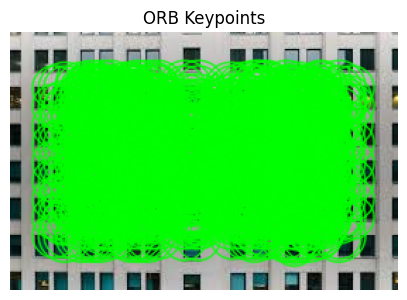


Trying SURF (may not be available)...
SURF is not available in this OpenCV build (patented / non-free).
Use SIFT or ORB instead for this demonstration.
Skipping SURF visualization.


In [28]:
def main(): 

    # ──────────────────────────────────────────────── 

    # Change this path to your test image 

    # Good choices: chessboard, building with corners/windows, textured object 

    image_path = "building facade2.jpg"               # ← Replace with real path 

    # image_path = "chessboard.jpg" 

    # image_path = "building facade.jpg" 

     

    try: 

        color_img, gray_img = load_and_prepare_image(image_path) 

    except FileNotFoundError as e: 

        print(e) 

        print("Please update 'image_path' variable with a valid image file.") 

        return 

     

    print(f"Image loaded: {gray_img.shape}") 

     

    # ────────────── SIFT ───────────────────────────── 

    print("\nComputing SIFT...") 

    kp_sift, des_sift = detect_and_compute_sift(gray_img) 

    print(f"SIFT → {len(kp_sift)} keypoints found") 

     

    if kp_sift: 

        draw_keypoints(color_img, kp_sift, "SIFT Keypoints") 

     

    # ────────────── ORB ────────────────────────────── 

    print("\nComputing ORB...") 

    kp_orb, des_orb = detect_and_compute_orb(gray_img, nfeatures=2000) 

    print(f"ORB  → {len(kp_orb)} keypoints found") 

     

    if kp_orb: 

        draw_keypoints(color_img, kp_orb, "ORB Keypoints") 

     

    # ────────────── SURF (may fail) ────────────────── 

    print("\nTrying SURF (may not be available)...") 

    kp_surf, des_surf = detect_and_compute_surf(gray_img) 

    if kp_surf: 

        print(f"SURF → {len(kp_surf)} keypoints found") 

        draw_keypoints(color_img, kp_surf, "SURF Keypoints") 

    else: 

        print("Skipping SURF visualization.") 

 

 

if __name__ == "__main__":

    main()

Image loaded: (163, 310)

Computing SIFT...
SIFT → 308 keypoints found


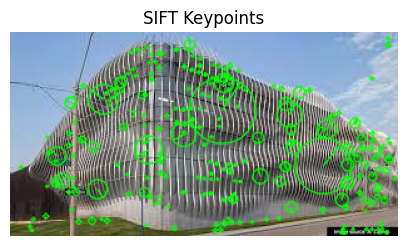


Computing ORB...
ORB  → 1187 keypoints found


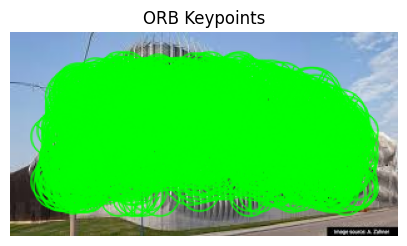


Trying SURF (may not be available)...
SURF is not available in this OpenCV build (patented / non-free).
Use SIFT or ORB instead for this demonstration.
Skipping SURF visualization.


In [29]:
def main(): 

    # ──────────────────────────────────────────────── 

    # Change this path to your test image 

    # Good choices: chessboard, building with corners/windows, textured object 

    image_path = "building.jpg"               # ← Replace with real path 

    # image_path = "chessboard.jpg" 

    # image_path = "building facade.jpg" 

     

    try: 

        color_img, gray_img = load_and_prepare_image(image_path) 

    except FileNotFoundError as e: 

        print(e) 

        print("Please update 'image_path' variable with a valid image file.") 

        return 

     

    print(f"Image loaded: {gray_img.shape}") 

     

    # ────────────── SIFT ───────────────────────────── 

    print("\nComputing SIFT...") 

    kp_sift, des_sift = detect_and_compute_sift(gray_img) 

    print(f"SIFT → {len(kp_sift)} keypoints found") 

     

    if kp_sift: 

        draw_keypoints(color_img, kp_sift, "SIFT Keypoints") 

     

    # ────────────── ORB ────────────────────────────── 

    print("\nComputing ORB...") 

    kp_orb, des_orb = detect_and_compute_orb(gray_img, nfeatures=2000) 

    print(f"ORB  → {len(kp_orb)} keypoints found") 

     

    if kp_orb: 

        draw_keypoints(color_img, kp_orb, "ORB Keypoints") 

     

    # ────────────── SURF (may fail) ────────────────── 

    print("\nTrying SURF (may not be available)...") 

    kp_surf, des_surf = detect_and_compute_surf(gray_img) 

    if kp_surf: 

        print(f"SURF → {len(kp_surf)} keypoints found") 

        draw_keypoints(color_img, kp_surf, "SURF Keypoints") 

    else: 

        print("Skipping SURF visualization.") 

 

 

if __name__ == "__main__":

    main()

<hr>